Project: Authorship Identification
======

In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV


from scipy.sparse import csr_matrix as sp_csr_matrix

In [2]:
# Load in C50train located ../C50train/
train_dir = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50train/'
# get name of directories, authors (these will be the labels)
train_sub = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
label_lst = np.copy(train_sub)

# setup the initial empty variables
train = []
train_v = []
label = []

# load the input data from C50train directory and process it
auth_idx = 0

# go within the author directory to get list of the file names, this will be the training data
for i in train_sub:
    sub2_dir  = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50train/' + i 
#     '../C50train/'
    train_sub2 = [name for name in os.listdir(sub2_dir) if os.path.isfile(os.path.join(sub2_dir, name))]
    # in each author file, save the author as the label and the text as its training data
    for j in train_sub2:
        sub3  = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50train/' + i + '/' + j

        with open(sub3, 'r') as file:
            data = file.read()
            data_no_nw = data.replace('\n', '').replace('\r', '')
            train.append(data_no_nw)
        # append author index as label
        label.append(auth_idx)
    # increment author index
    auth_idx = auth_idx + 1

## Step 2: Vectorize/Transform Data

In [3]:
# Step 2: Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
#     max_features=10000,  # Limit to the top 10,000 features for performance
    stop_words='english',  # Remove common English stopwords
    lowercase=True,  # Convert text to lowercase
    )


# Transform text data into TF-IDF feature vectors
X = tfidf_vectorizer.fit_transform(train)
y = np.array(label)

print(f"TF-IDF Feature Shape: {X.shape}")

TF-IDF Feature Shape: (2500, 29216)


In [ ]:
# def normalize_csr_matrix(csr_matrix):
#     norm_data = []
#     norm_rows = []
#     norm_cols = []
    
#     for i in range(csr_matrix.shape[0]):
#         row = csr_matrix[i].toarray().flatten()  # Convert row to a dense array and flatten it
#         norm = np.linalg.norm(row)  # Compute the L2 norm (Euclidean norm) of the row
        
#         # If the norm is not zero, normalize the row
#         if norm > 0:
#             norm_row = row / norm
#             # Collect non-zero entries
#             for j in range(len(norm_row)):
#                 if norm_row[j] != 0:
#                     norm_data.append(norm_row[j])
#                     norm_rows.append(i)  # Row index
#                     norm_cols.append(j)  # Column index

#     # Create a new sparse matrix from the normalized data
#     normalized_csr_matrix = sp_csr_matrix((norm_data, (norm_rows, norm_cols)), 
#                                            shape=csr_matrix.shape)
#     return normalized_csr_matrix

# X = normalize_csr_matrix(X)


## Step 3: Train-Test Split

In [4]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Train Set Shape: {X_train.shape}, Test Set Shape: {X_test.shape}")

Train Set Shape: (2125, 29216), Test Set Shape: (375, 29216)


## Step 4: Dimensionality Reduction + Hyperparameter Tuning

In [5]:
# Step 4: Dimensionality Reduction with Truncated SVD
svd = TruncatedSVD(n_components=1750, random_state=42) 

# Normalize the data
normalizer = Normalizer(norm='l2',copy=False)

# # Scale the data 
# scaler = StandardScaler()

In [6]:
# Initialize Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Define the parameter grid
param_grid = {
    'logisticregression__C': [0.1, 1, 10, 100],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__max_iter': [500],
}

# Create a pipeline with TruncatedSVD and Logistic Regression
pipeline = Pipeline([
    ('svd', svd),  # Use SVD as first step
    ('normalize',normalizer), # L-2 Normalization as second step
    ('logisticregression', logreg)  # Logistic regression as the third step
])

In [7]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # The pipeline with SVD and Logistic Regression
    param_grid=param_grid,  # Hyperparameter grid
    scoring='accuracy',  # Optimize Accuracy
    cv=5,  # Use 5-fold cross-validation
    verbose=1,  # Enable progress display
    return_train_score=True  # Include training scores for comparison
)

# Fit the GridSearchCV with training data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svd',
                                        TruncatedSVD(n_components=1750,
                                                     random_state=42)),
                                       ('normalize', Normalizer(copy=False)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.1, 1, 10, 100],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__max_iter': [500]},
             return_train_score=True, scoring='accuracy', verbose=1)

## Step 5: Logistic Regression Best Model - F1 Score + Classification Report

In [8]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the classification report
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'logisticregression__C': 100, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 500}

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         4
           2       0.80      0.80      0.80         5
           3       0.70      0.70      0.70        10
           4       1.00      0.75      0.86        12
           5       0.78      0.88      0.82         8
           6       1.00      1.00      1.00         4
           7       0.80      1.00      0.89         4
           8       0.75      0.50      0.60        12
           9       0.92      0.92      0.92        12
          10       0.88      1.00      0.93         7
          11       1.00      1.00      1.00         6
          12       0.88      0.78      0.82         9
          13       0.40      0.40      0.40         5
          14       0.67      0.6

In [9]:
# Step 6: Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

Weighted F1 Score: 0.8235


In [ ]:
# Analyze the Dimensionality Reduction
explained_variance_svd = svd.explained_variance_.sum()
print(f"Total Explained Variance by SVD: {explained_variance_svd:.4f}")

### Save Best Model

In [32]:
# import pickle
# # Save the model using pickle
# filename = 'logistic_regression_best_model.pkl'
# # pickle.dump(best_model, open(filename, 'wb'))

# # Load the model later
# loaded_model = pickle.load(open(filename, 'rb'))

In [33]:
# loaded_model

## Step 7: Predict on C50Test

In [10]:
# Load in C50test located ../C50test/
test_dir = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50test/'
# '../C50test'

# get name of directories, authors (these will be the labels)
test_sub = [name for name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, name))]
test_lst = np.copy(train_sub)

# setup the initial empty variables
test       = []
test_label = []

# load the input data from C50test directory and process it
auth_idx = 0

# go within the author directory to get list of the file names, this will be the training data
for i in train_sub:
    sub2_dir  = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50test/' + i 
    test_sub2 = [name for name in os.listdir(sub2_dir) if os.path.isfile(os.path.join(sub2_dir, name))]
    
    # in each author file, save the text as its test data
    for j in test_sub2:
        sub3  = 'C:/Users/esthe/Downloads/CMPE 255 Project/cmpe255-project/C50test/' + i + '/' + j

        with open(sub3, 'r') as file:
            data = file.read()
            data_no_nw = data.replace('\n', '').replace('\r', '')
            test.append(data_no_nw)
        
        test_label.append(auth_idx)

    auth_idx = auth_idx + 1


In [11]:
# Transform Test Data into TF-IDF Features
X_test_new = tfidf_vectorizer.transform(test)  # Use the trained vectorizer on test data
y_test_new = np.array(test_label)

print(f"Transformed Test Feature Shape: {X_test_new.shape}")
# X_test_new = normalize_csr_matrix(X_test_new)

Transformed Test Feature Shape: (2500, 29216)


In [25]:
# Step 2: Predict on Test Data
y_pred_new = best_model.predict(X_test_new)

# Step 3: Evaluate Model on Test Data
print("Classification Report on Test Data:")
print(classification_report(y_test_new, y_pred_new))

# Optional: Calculate Weighted F1 Score
f1_new = f1_score(y_test_new, y_pred_new, average='macro')
print(f"Weighted F1 Score on Test Data: {f1_new:.4f}")

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        50
           1       0.90      0.52      0.66        50
           2       0.50      0.32      0.39        50
           3       0.38      0.26      0.31        50
           4       0.86      0.48      0.62        50
           5       0.56      0.96      0.71        50
           6       0.38      0.28      0.32        50
           7       0.67      0.48      0.56        50
           8       0.92      0.44      0.59        50
           9       0.45      0.54      0.49        50
          10       0.98      1.00      0.99        50
          11       0.77      0.92      0.84        50
          12       0.32      0.38      0.35        50
          13       0.19      0.10      0.13        50
          14       0.59      0.46      0.52        50
          15       0.89      1.00      0.94        50
          16       0.58      0.68      0.62  

SVD: 

    accuracy                           0.62      2500

Weighted F1 Score on Test Data: 

**w/ GridSearch best_model:** (Test_size = 0.15)

    accuracy                           0.66      2500

Weighted F1 Score on Test Data: 0.6596




PCA:

    accuracy                           0.61      2500

Weighted F1 Score on Test Data: 0.6059

**w/ GridSearch best_model:**

    accuracy                           0.66      2500
    
Weighted F1 Score on Test Data: 0.6591

## Plots

In [ ]:
# Fit PCA on the training data
pca = PCA()  # Initialize PCA to capture all components
X_train_pca = pca.fit_transform(X_train.toarray())  # Convert to dense matrix if needed

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_)

# Normalize cumulative variance for scaling purposes (optional)
total_variance = cumulative_variance[-1]  # Total variance
normalized_cumulative_variance = cumulative_variance / total_variance

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, linestyle='-', color='b', label='Cumulative Variance')
# plt.plot(normalized_cumulative_variance, linestyle='-', color='g', label='Normalized Variance')
plt.title('Cumulative Explained Variance vs Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.axhline(y=0.85 * total_variance, color='r', linestyle='--', label='85% Variance')
plt.axhline(y=0.90 * total_variance, color='purple', linestyle='--', label='90% Variance')
plt.legend(loc='best')
plt.show()


In [ ]:
# Fit PCA on the training data
pca = PCA()  # Initialize PCA with all components
X_train_pca = pca.fit_transform(X_train.toarray())  # Ensure X_train is dense if sparse

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.85, color='r', linestyle='--', label='85% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.legend(loc='best')
plt.show()


In [ ]:
# Define the range of n_components to explore
components_range = [0,500,750,1000,1200,1500]
explained_variances = []

# Fit PCA for each number of components and record the cumulative explained variance
for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(X_train.toarray())  # Convert sparse matrix to dense if necessary
    explained_variances.append(np.sum(pca.explained_variance_))  # Cumulative explained variance

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(components_range, explained_variances, marker='o', color='b', linestyle='-', markersize=3)
plt.title('Explained Variance vs. Number of PCA Components')
plt.xlabel('Number of Components (n)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# List of test sizes to evaluate
test_sizes = [0.10,0.15,0.20,0.25,0.30]  # Test sizes from 10% to 50%
f1_scores = []

# Evaluate the model for each test size
for test_size in test_sizes:
    # Split the data
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    # Train the model
    pipeline.fit(X_train_split, y_train_split)
    
    # Predict and evaluate
    y_pred_split = pipeline.predict(X_test_split)
    f1 = f1_score(y_test_split, y_pred_split, average='macro')
    f1_scores.append(f1)

    if debug:
        print(f"Test Size: {test_size:.2f}, F1 Score: {f1:.4f}")

# Plot Test Size vs. F1-Score
plt.plot(test_sizes, f1_scores, marker='o', linestyle='-', color='b')
plt.title("Test Size vs. F1-Score")
plt.xlabel("Test Size")
plt.ylabel("F1-Score")
plt.grid()
plt.show()


In [ ]:
from wordcloud import WordCloud
all_text = " ".join(train)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words")
plt.show()


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X[:1000].toarray())  # Use a subset for efficiency
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label[:1000], cmap='viridis', s=5)
plt.colorbar()
plt.title("t-SNE Visualization of Feature Space")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# highlight which classes are misclassified
cm = confusion_matrix(y_test_new, y_pred_new)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=label_lst, yticklabels=label_lst)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


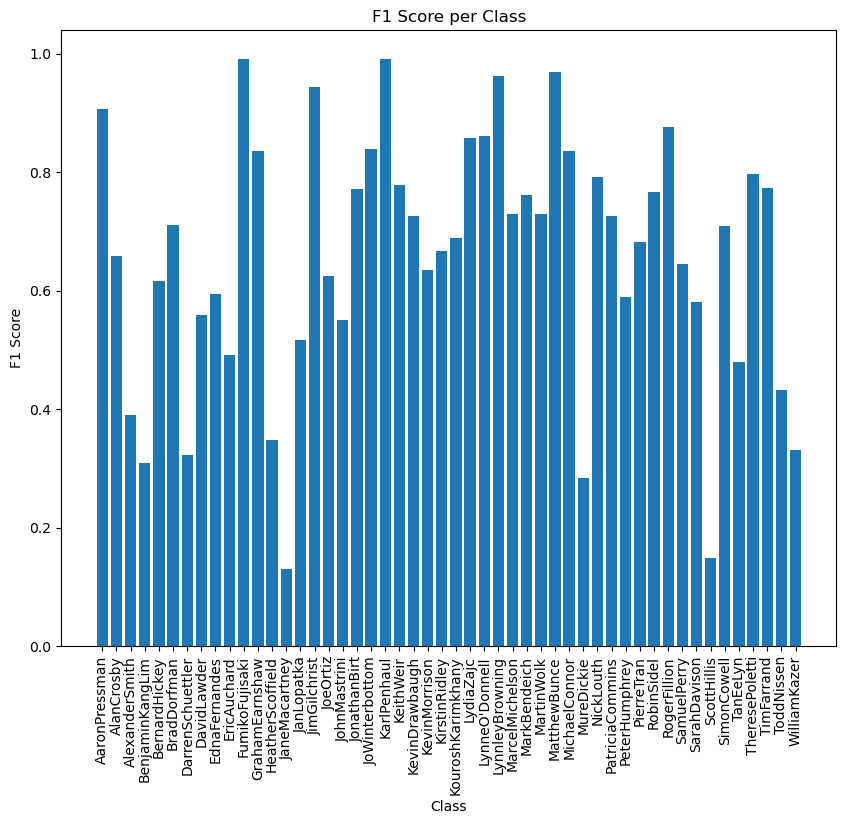

In [31]:
from sklearn.metrics import classification_report

plt.figure(figsize=(10, 8))
report = classification_report(y_test_new, y_pred_new, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_lst))]
plt.bar(label_lst, f1_scores)
plt.title("F1 Score per Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.xticks(rotation=90)
plt.show()
